## Analyzing river profile concavity in the Snohomish & Stillaguamish basins
This notebook was created as part of a final project for Alison Duvall's tectonic geomorphology class. It imports DEMs of the Snohomish and Stillaguamish basin using landlab and extracts the channel network. These profiles are then compared against an idealized profile created using Hack's law with expected ks and theta values.

The goal of this project was to estimate how much uplift would be necessary to erase the concavity difference between the Cascade Mtn regions and lowland Puget Sound. This concavity difference reflects river disequillibrium in response to the last continental glaciation. 

References: Collins & Montgomery, 2013 (https://doi.org/10.1016/j.geomorph.2010.11.002)
_________________________________________

Import packages

In [1]:
import os
import numpy as np
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab import imshow_grid_at_node
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from landlab.components import ChannelProfiler, FlowAccumulator
from scipy.interpolate import interp1d
fttom= 0.3048

Define a Hack's law function:

In [2]:
def S_hacks(ks, A, theta):
    S = ks*A**(-theta)
    return(S)

## Shomoish Basin Channel Analysis
Import a DEM

In [3]:
fname = os.path.join(os.getcwd(), 'data\snohomish_elev_100m_gdalwarp.asc')
mg, z = read_esri_ascii(fname, name='topographic__elevation')

Close all no data values

In [ ]:
mg.status_at_node[np.isclose(z, 0.)] = mg.BC_NODE_IS_CLOSED

Find the watershed outlet to make the flow accumlator run faster. 

* Note: The commented line below returns a ValueError becuase there are multiple possible outlet nodes. Use the list at the bottom of the error message to select one of the possible nodes to 'force' to be your outlet node. (You can plot them up if you'd like to see which is closest to your desired outlet)
* see: https://landlab.readthedocs.io/en/master/reference/grid/raster_api.html#landlab.grid.raster.RasterModelGrid.set_watershed_boundary_condition

In [14]:
#mg.set_watershed_boundary_condition('topographic__elevation', 0., True)

Force one of the outlet nodes (obtained from error message above) to be a fixed outlet node value.

In [4]:
mg.status_at_node[634982] = mg.BC_NODE_IS_FIXED_VALUE #this makes the flow accumulator run a ton faster!

Instantiate and run the FlowAccumulator (required for the ChannelProfiler)

In [6]:
fa = FlowAccumulator(mg, 
                     'topographic__elevation',
                     flow_director='D8',
                     depression_finder='DepressionFinderAndRouter')
fa.run_one_step()

Instantiate and run the ChannelProfiler for the entire channel network:

In [7]:
profiler2 = ChannelProfiler(
    mg,
    number_of_watersheds=1,
    minimum_channel_threshold=(50000000),
    main_channel_only=False,
)
profiler2.run_one_step()

Instantiate and run the ChannelProfiler for the main channel only:

In [8]:
profiler2_mainchannel = ChannelProfiler(
    mg,
    number_of_watersheds=1,
    minimum_channel_threshold=(50000000),
#     outlet_nodes=[176868],
    main_channel_only=True,
)
profiler2_mainchannel.run_one_step()

Extract the data for the profile network and mainchannel data using the watershed outlet key:

In [24]:
profile_data2 = profiler2.data_structure[634982]

In [28]:
profiler2_mainchannel_data = profiler2_mainchannel.data_structure[634982]

### Plotting the Shonomish Basin:

Plot the DEM overlayed with the channel profiles:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:269: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(alpha=0.0)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


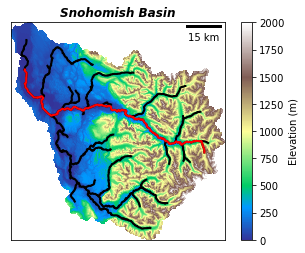

In [322]:
f, ax = plt.subplots()
imshow_grid_at_node(mg, z/10, cmap='terrain', colorbar_label='Elevation (m)', color_for_closed=None,
                   vmin=0, vmax=2000)
plt.title('Snohomish Basin', fontweight='bold', fontstyle='italic')
#plot profile data
for item in profile_data2:
    ax.plot(mg.x_of_node[profile_data2[item]['ids']],
            mg.y_of_node[profile_data2[item]['ids']],
            color='k',
            linewidth=2)
for item in profiler2_mainchannel_data:
    ax.plot(mg.x_of_node[profiler2_mainchannel_data[item]['ids']],
            mg.y_of_node[profiler2_mainchannel_data[item]['ids']],
            color='red',
            linewidth=2)
# n_val = 625 #try to find deliniation of glacial 
# ax.scatter(mg.x_of_node[profiler2_mainchannel_data[item]['ids'][n_val]],
#            mg.y_of_node[profiler2_mainchannel_data[item]['ids'][n_val]],
#            color='magenta')
#make ticks invisible
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
ax.add_artist(ScaleBar(1.0))
plt.savefig('snohomish_basin_mainchannel.png',
            dpi=300)

Plot the profiles as distance upstream vs elevation

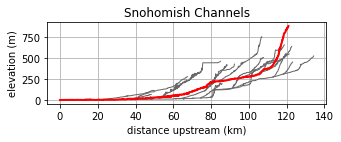

In [321]:
f, ax = plt.subplots(figsize=(5,1.5))
for item in profile_data2:
    ax.plot(profile_data2[item]['distances']/1000,
            z[profile_data2[item]['ids']]/10,
            color='dimgrey',
            linewidth=1)
for item in profiler2_mainchannel_data:
    ax.plot(profiler2_mainchannel_data[item]['distances']/1000,
            z[profiler2_mainchannel_data[item]['ids']]/10,
            color='red',
            linewidth=2)
# identify glacial and post glacial valleys
# ax.scatter(profiler2_mainchannel_data[item]['distances'][n_val]/1000,
#            z[profiler2_mainchannel_data[item]['ids']][n_val]/10)
# ax.axvspan(0,40, alpha=0.2, color='blue') #glacial
# ax.axvspan(40,80, alpha=0.2, color='orange') #post glacial
ax.grid(True)
ax.set_ylabel('elevation (m)')
ax.set_xlabel('distance upstream (km)')
ax.set_title('Snohomish Channels')
# ax.set_ylim([0,500])
plt.savefig('snohomish_channels_main.png',
            dpi=300,
            bbox_inches='tight')

Extract drainage area data and calculate slopes of profiles to compare slope vs area and calculate idealized slope plots

In [400]:
da_mainchannel_sno = mg.at_node['drainage_area'][profiler2_mainchannel_data[(634982,325860)]['ids']]
d_mainchannel_sno = profiler2_mainchannel_data[(634982,325860)]['distances']
elev_mainchannel_sno = z[profiler2_mainchannel_data[(634982,325860)]['ids']]
s_mainchannel_sno = np.divide(np.diff(elev_mainchannel_sno), np.diff(d_mainchannel_sno))

Create smoothed mainstem profile--this is necessary because the original DEM was very coarse leading to unreasonably noisy slopes due to resolution limitations. With a finer DEM, you could likely just use the slope calculated from the channel profile.

In [445]:
f_smooth_elev = interp1d(d_mainchannel_sno, elev_mainchannel_sno, kind='cubic')
n_sampled = 10
x_new = d_mainchannel_sno[0::n_sampled]
da_new = da_mainchannel_sno[0::n_sampled]
elev_smoothed = f_smooth_elev(x_new)
s_mainchannel_sno_smoothed = np.divide(np.diff(elev_smoothed), np.diff(x_new))

Calculate a forecasted equlibrium profile slope using Hack's Law for the drainage area along the channel.

In [446]:
theta = 0.5
ks = 300 #in units of decameters for theta=0.5, divide by 10 for ksn in units of m
S_mainchannel_sno = S_hacks(ks, da_mainchannel_sno, theta) #equib slope

Calculate the equibrium profile using the equilibrium slope.

In [447]:
dE_sno = S_mainchannel_sno[1:]*np.diff(d_mainchannel_sno)

In [448]:
elevs_equib_sno = np.zeros(len(d_mainchannel_sno)) #empty vector to hold new elev data
elevs_equib_sno[0] = elev_mainchannel_sno[0] #set initial elev as existing elev
for i in range(1,len(d_mainchannel_sno)):
    elevs_equib_sno[i] = elevs_equib_sno[i-1] + dE_sno[i-1] #E(i) = E(i-1) + S*dx

Slope area plot of present mainstem shonomish channel and 'equilibrium' channel.

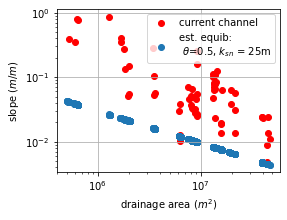

In [449]:
f, ax = plt.subplots(figsize=(4,3))
ax.scatter(da_new[:-1]/(10*10),
          s_mainchannel_sno_smoothed,
          label='current channel',
           color='red')
ax.scatter(da_mainchannel_sno/(10*10),
        S_mainchannel_sno,
          label='est. equib: \n' + r' $\theta$=0.5, $k_{sn}$ = 25m')
ax.set_xlabel('drainage area $(m^2)$')
ax.set_ylabel('slope $(m/m)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid()
plt.savefig(r'slope_area_sno.png',
            dpi=300,
            bbox_inches='tight')

Plot of Channel Profile Data & equilibrium profile

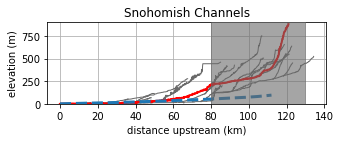

In [425]:
f, ax = plt.subplots(figsize=(5,1.5))
for item in profile_data2:
    ax.plot(profile_data2[item]['distances']/1000,
            z[profile_data2[item]['ids']]/10,
            color='dimgrey',
            linewidth=1)
for item in profiler2_mainchannel_data:
    ax.plot(profiler2_mainchannel_data[item]['distances']/1000,
            z[profiler2_mainchannel_data[item]['ids']]/10,
            color='red',
            linewidth=2)
# ax.plot(x_new,
#         f_smooth_elev(x_new)/10,
#         linewidth=3)
ax.plot(d_mainchannel_sno[:-80]/1000,
        elevs_equib_sno[:-80]/10,
        linestyle='--',
        linewidth=3)
ax.axvspan(80, 130, color='dimgrey', alpha=0.6, zorder=3)
ax.grid(True)
ax.set_ylabel('elevation (m)')
ax.set_xlabel('distance upstream (km)')
ax.set_title('Snohomish Channels')
ax.set_ylim([0,900])
plt.savefig('snohomish_channels_mainchannel.png',
            dpi=300,
            bbox_inches='tight')

## Stillaguamish Basin Channel Analysis

Import a DEM

In [15]:
fname2 = os.path.join(os.getcwd(), 'data\stillaguamish_elev_100m_gdalwarp.asc')
mg2, z2 = read_esri_ascii(fname2, name='topographic__elevation')

Close boundary nodes:

In [16]:
mg2.status_at_node[np.isclose(z2, 0.)] = mg2.BC_NODE_IS_CLOSED

Since channel abuts the left boundary, fix these for the Flow Accumulator 

In [17]:
mg2.status_at_node[mg2.nodes_at_left_edge] = mg2.BC_NODE_IS_FIXED_VALUE

Run flow accumulator:

In [18]:
fa = FlowAccumulator(mg2, 
                     'topographic__elevation',
                     flow_director='D8',
                     depression_finder='DepressionFinderAndRouter')
fa.run_one_step()

Use the following commented code block to find the prospective outlet node of the channel. This will return an error--use the list of possible outlet nodes to select an outlet node to force the ChannelProfiler to use. (Helps it run!)

In [20]:
#mg2.set_watershed_boundary_condition('topographic__elevation', 0., True)

Run ChannelProfiler for entire network

In [21]:
profiler = ChannelProfiler(
    mg2,
    number_of_watersheds=1,
    minimum_channel_threshold=(50000000),
    outlet_nodes=[176868],
    main_channel_only=False,
)
profiler.run_one_step()

Run ChannelProfiler for mainstem

In [42]:
profiler_mainchannel = ChannelProfiler(
    mg2,
    number_of_watersheds=1,
    minimum_channel_threshold=(50000000),
    outlet_nodes=[176868],
    main_channel_only=True,
)
profiler_mainchannel.run_one_step()

Extract channel profiler data and mainstem data using watershed outlet key

In [43]:
profile_data = profiler.data_structure[176868]
profile_mainchannel_data = profiler_mainchannel.data_structure[176868]

Plot Stillaguamish DEM with channel network

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:269: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(alpha=0.0)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


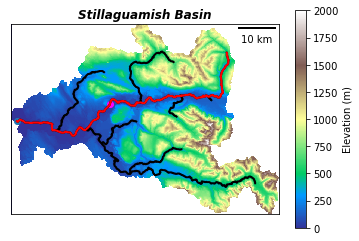

In [482]:
f, ax = plt.subplots()
imshow_grid_at_node(mg2, z2/10, cmap='terrain', colorbar_label='Elevation (m)', color_for_closed=None,
                   vmin=0, vmax=2000)
#make ticks invisible
plt.title('Stillaguamish Basin', fontweight='bold', fontstyle='italic')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
ax.add_artist(ScaleBar(1.0))
#plot channel data
for item in profile_data:
    ax.plot(mg2.x_of_node[profile_data[item]['ids']],
            mg2.y_of_node[profile_data[item]['ids']],
            color='k',
            linewidth=2)
for item in profile_mainchannel_data:
    ax.plot(mg2.x_of_node[profile_mainchannel_data[item]['ids']],
            mg2.y_of_node[profile_mainchannel_data[item]['ids']],
            color='red',
            linewidth=2)
n_val = 300 #try to find deliniation of glacial 
ax.scatter(mg2.x_of_node[profile_mainchannel_data[item]['ids'][n_val]],
           mg2.y_of_node[profile_mainchannel_data[item]['ids'][n_val]],
           color='magenta')
#plot watershed outlet node
ax.scatter(mg2.x_of_node[176868], mg2.y_of_node[176868])
# plt.show()
plt.savefig('stillaguamish_basin_mainchannel.png',
            dpi=300)

plot profiler data

In [114]:
# plt.figure(figsize = (6,6))
# profiler.plot_profiles_in_map_view(colorbar_label='elevation')

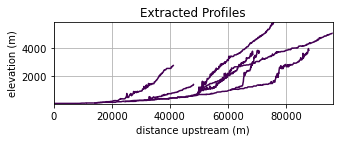

In [323]:
f, ax = plt.subplots(figsize=(5,1.5))
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')
ax.grid(True)

Extract data to compare slope vs area and calculate idealized slope plots

In [489]:
da_mainchannel_stilly = mg2.at_node['drainage_area'][profile_mainchannel_data[(176868,308457)]['ids']]
d_mainchannel_stilly = profile_mainchannel_data[(176868,308457)]['distances']
elev_mainchannel_stilly = z2[profile_mainchannel_data[(176868,308457)]['ids']]
s_mainchannel_stilly = np.divide(np.diff(elev_mainchannel_stilly), np.diff(d_mainchannel_stilly))

Create smoothed mainstem profile

In [490]:
f_smooth_elev = interp1d(d_mainchannel_stilly, elev_mainchannel_stilly, kind='cubic')
n_sampled = 10
x_new = d_mainchannel_stilly[0::n_sampled]
da_new = da_mainchannel_stilly[0::n_sampled]
elev_smoothed = f_smooth_elev(x_new)

Smooth slope (quite noisy..)

In [491]:
s_mainchannel_stilly_smoothed = np.divide(np.diff(elev_smoothed), np.diff(x_new))

Calculate equib profile slope

In [492]:
theta = 0.5
ks = 250 #in units of decameters for theta=0.5, divide by 10 for ksn in units of m
S_mainchannel_stilly = S_hacks(ks, da_mainchannel_stilly, theta) #equib slope

Calc equib profile

In [493]:
dE = S_mainchannel_stilly[1:]*np.diff(d_mainchannel_stilly)

In [494]:
elevs_equib = np.zeros(len(d_mainchannel_stilly)) #empty vector to hold new elev data
elevs_equib[0] = elev_mainchannel_stilly[0] #set initial elev as existing elev
for i in range(1,len(d_mainchannel_stilly)):
    elevs_equib[i] = elevs_equib[i-1] + dE[i-1] #E(i) = E(i-1) + S*dx

Stillaguamish DA vs Slope plot with idealized channel:

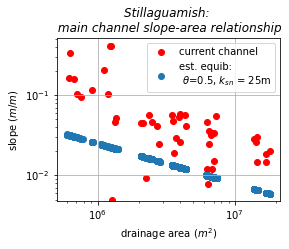

In [495]:
f, ax = plt.subplots(figsize=(4,3))
ax.scatter(da_new[:-1]/(10*10),
          s_mainchannel_stilly_smoothed,
          label='current channel',
          color='red')
ax.scatter(da_mainchannel_stilly/(10*10),
        S_mainchannel_stilly,
          label='est. equib: \n' + r' $\theta$=0.5, $k_{sn}$ = 25m')
ax.set_xlabel('drainage area $(m^2)$')
ax.set_ylabel('slope $(m/m)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Stillaguamish: \n main channel slope-area relationship', fontstyle='italic')
ax.grid()
plt.savefig(r'slope_area_stilly.png',
            dpi=300,
            bbox_inches='tight')

Plot Channel Profile Data & equilibrium

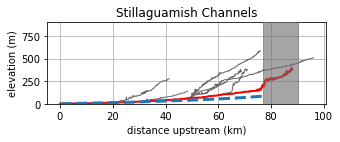

In [499]:
f, ax = plt.subplots(figsize=(5,1.5))
for item in profile_data:
    ax.plot(profile_data[item]['distances']/1000,
            z2[profile_data[item]['ids']]/10,
            color='dimgrey',
            linewidth=1)
for item in profile_mainchannel_data:
    ax.plot(profile_mainchannel_data[item]['distances']/1000,
            z2[profile_mainchannel_data[item]['ids']]/10,
            color='red',
            linewidth=2)
# ax.plot(x_new,
#         f_smooth_elev(x_new)/10,
#         linewidth=3)
ax.plot(d_mainchannel_stilly[:-100]/1000,
        elevs_equib[:-100]/10,
        linestyle='--',
        linewidth=3)
# ax.scatter(profile_mainchannel_data[item]['distances'][n_val]/1000,
#            z2[profile_mainchannel_data[item]['ids']][n_val]/10)
ax.axvspan(77, 90, color='dimgrey', alpha=0.6, zorder=3)
ax.grid(True)
ax.set_ylabel('elevation (m)')
ax.set_xlabel('distance upstream (km)')
ax.set_title('Stillaguamish Channels')
ax.set_ylim([0,900])
plt.savefig('stillaguamish_channels_mainchannel.png',
            dpi=300,
            bbox_inches='tight')